In [1]:
#RANDOM FOREST REGRESSION

In [3]:
#imports 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [5]:
#to load the splits 
train_path = "data/splits/airq_train.csv"
val_path   = "data/splits/airq_val.csv"
test_path  = "data/splits/airq_test.csv"

#read csv files
df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

#to check proper ordering
df_train = df_train.sort_values("timestamp").reset_index(drop=True)
df_val   = df_val.sort_values("timestamp").reset_index(drop=True)
df_test  = df_test.sort_values("timestamp").reset_index(drop=True)

df_train.head()


,timestamp,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,150.0,11.9,166.0,113.0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,112.0,9.4,103.0,92.0,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,88.0,9.0,131.0,114.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,80.0,9.2,172.0,122.0,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,51.0,6.5,131.0,116.0,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


In [7]:
#data configuration for regression tasks
POLLUTANTS = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
HORIZONS = [1, 6, 12, 24]
EXCLUDE = ["timestamp"]


In [9]:
#helper function to shift target
def add_target(df, pollutant, H):
    df = df.copy()
    df[f"{pollutant}_target"] = df[pollutant].shift(-H)
    return df.dropna(subset=[f"{pollutant}_target"])

In [11]:
#handling NaNs
from sklearn.impute import SimpleImputer

In [13]:
imputer_global = SimpleImputer(strategy="mean")

results = []
models = {}

for pollutant in POLLUTANTS:
    for H in HORIZONS:

        #horizon specific targets added with each split
        tr = add_target(df_train, pollutant, H)
        vl = add_target(df_val, pollutant, H)
        te = add_target(df_test, pollutant, H)

        target_col = f"{pollutant}_target"

        feature_cols = [
            c for c in tr.columns
            if c not in EXCLUDE and c != target_col
        ]

        #to select features
        X_train, y_train = tr[feature_cols], tr[target_col]
        X_val,   y_val   = vl[feature_cols], vl[target_col]
        X_test,  y_test  = te[feature_cols], te[target_col]

        #to drop the NaN target rows
        train_mask = y_train.notna()
        val_mask   = y_val.notna()
        test_mask  = y_test.notna()

        X_train, y_train = X_train[train_mask], y_train[train_mask]
        X_val,   y_val   = X_val[val_mask],     y_val[val_mask]
        X_test,  y_test  = X_test[test_mask],   y_test[test_mask]

        #to skip degenerate cases
        if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
            print(f"Skipping pollutant={pollutant}, horizon={H} because one split is empty")
            continue

        #fitting on train
        imputer = SimpleImputer(strategy="mean")  
        X_train = pd.DataFrame(
            imputer.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index,
        )
        X_val = pd.DataFrame(
            imputer.transform(X_val),
            columns=X_val.columns,
            index=X_val.index,
        )
        X_test = pd.DataFrame(
            imputer.transform(X_test),
            columns=X_test.columns,
            index=X_test.index,
        )

        #to train RF on train and evaluate on val
        rf = RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=0,
        )
        rf.fit(X_train, y_train)

        pred_val = rf.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))

        #to retrain on train+val and evaluate on test
        X_train_full = pd.concat([X_train, X_val])
        y_train_full = pd.concat([y_train, y_val])

        rf.fit(X_train_full, y_train_full)

        pred_test = rf.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

        #Naive baseline:
        #y_hat(t) = y(t) to predict y(t+H)
        #Evaluate baseline ONLY on the same rows used for y_test.
        baseline_true = y_test
        baseline_input = te.loc[y_test.index, pollutant]  # y(t) at those timestamps

        valid = baseline_true.notna() & baseline_input.notna()
        if valid.any():
            baseline_rmse = np.sqrt(
                mean_squared_error(
                    baseline_true[valid],
                    baseline_input[valid],
                )
            )
        else:
            baseline_rmse = np.nan

        results.append({
            "pollutant": pollutant,
            "horizon": H,
            "rmse_val": rmse_val,
            "rmse_test": rmse_test,
            "baseline_rmse": baseline_rmse,
        })

        #save model
        models[(pollutant, H)] = {
            "model": rf,
            "imputer": imputer,
            "features": feature_cols,
        }

Skipping pollutant=NMHC(GT), horizon=1 because one split is empty
Skipping pollutant=NMHC(GT), horizon=6 because one split is empty
Skipping pollutant=NMHC(GT), horizon=12 because one split is empty
Skipping pollutant=NMHC(GT), horizon=24 because one split is empty


In [15]:
#to view results
df_results = pd.DataFrame(results)
df_results

,pollutant,horizon,rmse_val,rmse_test,baseline_rmse
0,CO(GT),1,1.013982,0.712876,0.786798
1,CO(GT),6,1.614961,1.388189,1.784794
2,CO(GT),12,1.845744,1.452715,1.658548
3,CO(GT),24,1.639458,1.213044,1.140668
4,C6H6(GT),1,4.116225,3.580902,3.708965
5,C6H6(GT),6,7.862724,6.276959,8.174460
6,C6H6(GT),12,8.619834,6.737470,7.697931
7,C6H6(GT),24,7.583864,5.884986,5.183827
8,NOx(GT),1,127.579432,100.913635,107.193762
9,NOx(GT),6,264.179425,201.915924,252.176153


In [17]:
#save result
df_results.to_csv("rf_regression_results.csv", index=False)

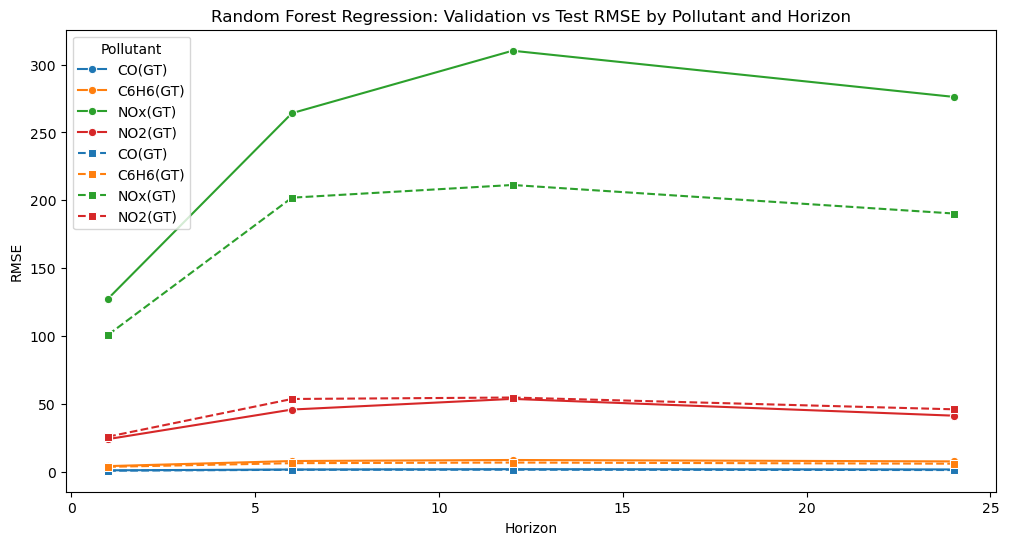

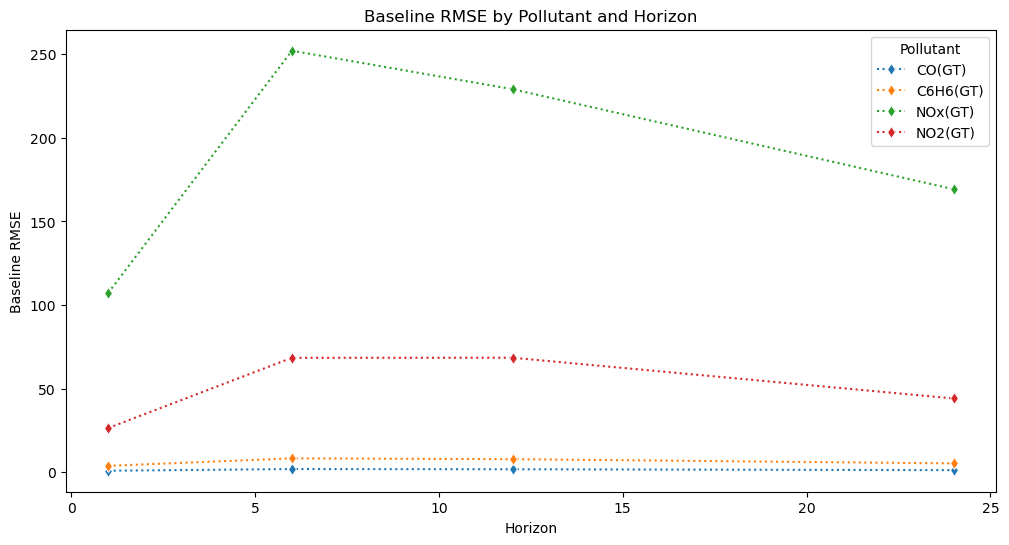

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_results = pd.read_csv("rf_regression_results.csv")

#RMSE plots for each pollutant across horizons
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x="horizon", y="rmse_val", hue="pollutant", marker="o")
sns.lineplot(data=df_results, x="horizon", y="rmse_test", hue="pollutant", marker="s", linestyle="--")
plt.title("Random Forest Regression: Validation vs Test RMSE by Pollutant and Horizon")
plt.xlabel("Horizon")
plt.ylabel("RMSE")
plt.legend(title="Pollutant")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x="horizon", y="baseline_rmse", hue="pollutant", marker="d", linestyle=":")
plt.title("Baseline RMSE by Pollutant and Horizon")
plt.xlabel("Horizon")
plt.ylabel("Baseline RMSE")
plt.legend(title="Pollutant")
plt.show()


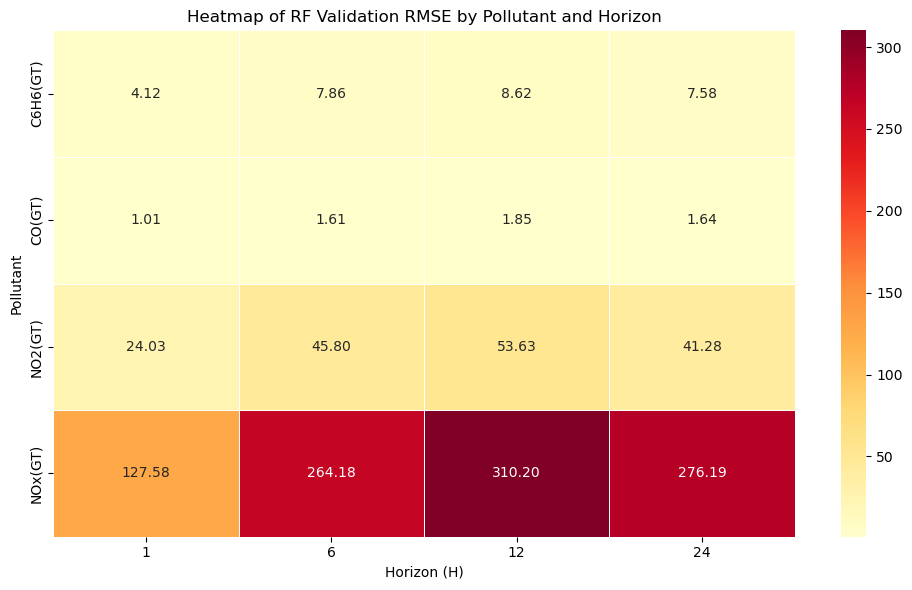

In [21]:
#Heatmap: Validation RMSE for each pollutant vs horizon
pivot_val = df_results.pivot(index='pollutant', columns='horizon', values='rmse_val')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_val, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=.5)
plt.title("Heatmap of RF Validation RMSE by Pollutant and Horizon")
plt.ylabel("Pollutant")
plt.xlabel("Horizon (H)")
plt.tight_layout()
plt.show()

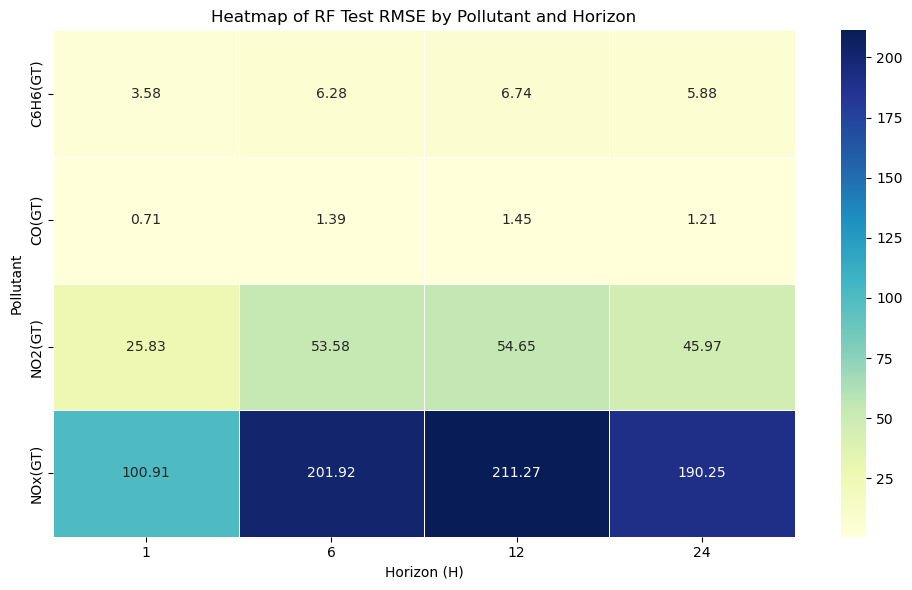

In [23]:
#Heatmap: Test RMSE for each pollutant vs horizon
pivot_test = df_results.pivot(index='pollutant', columns='horizon', values='rmse_test')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_test, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap of RF Test RMSE by Pollutant and Horizon")
plt.ylabel("Pollutant")
plt.xlabel("Horizon (H)")
plt.tight_layout()
plt.show()


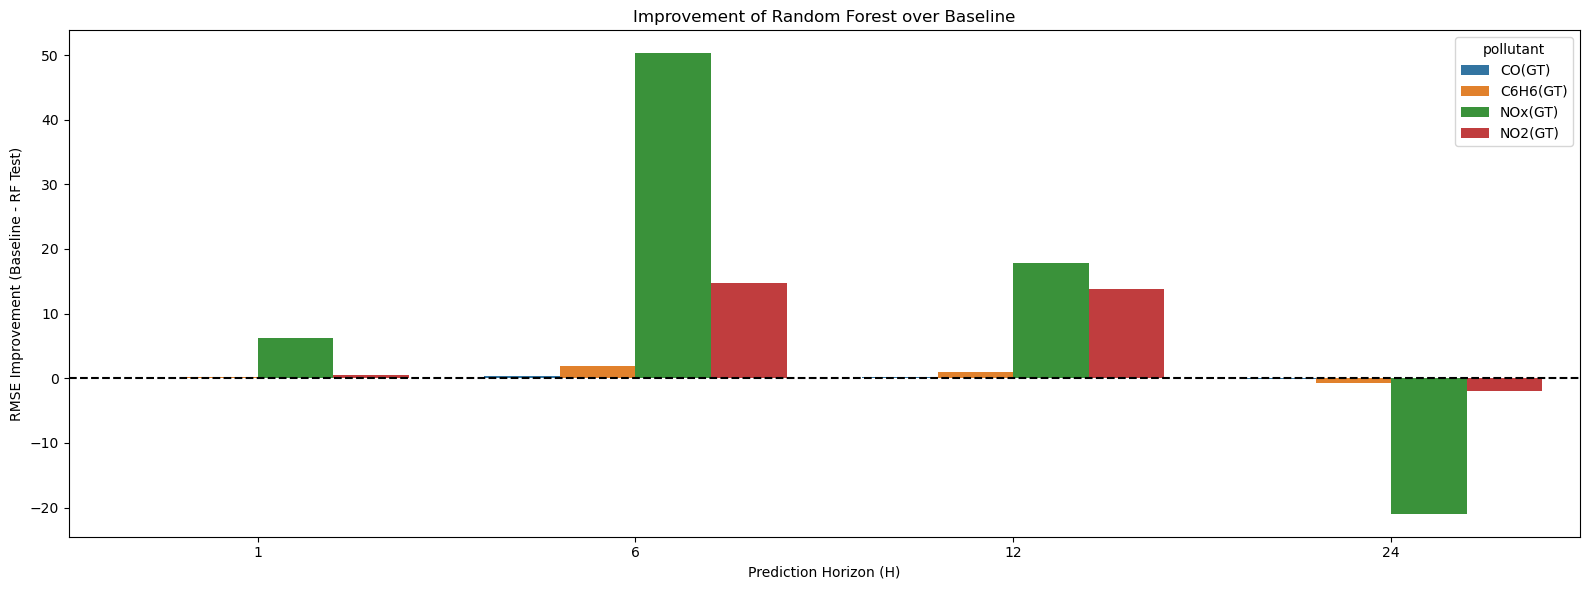

In [31]:
#to compute RMSE improvement (baseline - RF test)
df_results['rmse_diff'] = df_results['baseline_rmse'] - df_results['rmse_test']

#plot
plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x='horizon', y='rmse_diff', hue='pollutant')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Prediction Horizon (H)")
plt.ylabel("RMSE Improvement (Baseline - RF Test)")
plt.title("Improvement of Random Forest over Baseline")
plt.tight_layout()
plt.show()
